## This notebook is for pre-processing liveability factor data

### 1. Setting up the coding environment (Nene)

In [313]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler

In [314]:
# Function to save cleaned dataframe

def save_data(dataframe, dest: str, name: str):
    file = os.path.join(dest, name)  # dest/name

    # If the file is not existing...
    if not os.path.isfile(file):
        print(f"{file} not found, saving...")
        path = os.path.split(dest)  # dest1, dest2

        # Make sure the destination file exits
        if len(path) >= 1 and path[0] != "":
            os.makedirs(os.path.join(*path), exist_ok=True)

        # Save the file
        dataframe.to_csv(file, index=False)

        print("\tDone saving.")

    else:
        print(f"Found {file} locally, done!")

    return

### 2. Reading and cleaning data (Nene & Richy)

| Metric | Data | Unit | Year | Link |
| :- | -: | :- | :-: | :- |
| 1_Transportation | PTAL | Ward | 2013 | https://data.london.gov.uk/dataset/london-ward-well-being-scores |
| 2_Neighbourhood | Green and open space access | Ward | 2013 | (same as above) |
| 3_Opportunity | Average GCSE scores | Ward | 2013 | (same as above) |
| 4_Housing | Median house price | Ward | 2014* | https://data.london.gov.uk/dataset/ward-profiles-and-atlas |
| 5_Environment | Pollution impact | Ward | 2008* | https://data.london.gov.uk/dataset/estimation-health-impacts-particulate-pollution-london |
| 6_Safety | Road Collisions | Ward | 2013 | https://data.london.gov.uk/dataset/road-collisions-severity |
| 7_Future prospect | Change in house price | Ward | (tbd)* | https://data.london.gov.uk/dataset/average-house-prices |
| Population | Population | Ward | 2015 | https://data.london.gov.uk/dataset/ward-profiles-and-atlas |

In [315]:
# Initialise the dataframe to store all data
df_combined = pd.DataFrame()

#### 1 & 2 & 3 - from well-being scores

In [582]:
# Reading in the data

file = os.path.join('data', 'raw', 'well_being_data.csv')
cols = ['Ward', 'New ward code', 'Public Transport Accessibility - 2013', 
        'Homes with access to open space & nature, and % greenspace - 2013',
        'GCSE point scores - 2013', ]

df_well_being = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [583]:
# Renaming columns
df_well_being.rename(columns={"Ward": "ward_name", 
                           "New ward code": "ward_code",
                           "GCSE point scores - 2013": "gcse_2013",
                           "Public Transport Accessibility - 2013": "ptal_2013",
                           "Homes with access to open space & nature, and % greenspace - 2013": 'nature_access_2013'},
                  inplace=True)

df_well_being.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ward_code           659 non-null    object 
 1   ward_name           657 non-null    object 
 2   gcse_2013           660 non-null    float64
 3   ptal_2013           659 non-null    float64
 4   nature_access_2013  659 non-null    float64
dtypes: float64(3), object(2)
memory usage: 27.9+ KB


In [584]:
df_well_being.head()

,ward_code,ward_name,gcse_2013,ptal_2013,nature_access_2013
0,NaN,NaN,NaN,NaN,NaN
1,E09000001,City of London,360.0,7.9,-6.5
2,E05000026,Abbey,334.0,6.0,-0.9
3,E05000027,Alibon,323.0,3.1,-1.8
4,E05000028,Becontree,319.0,2.9,-5.5


In [585]:
df_well_being = df_well_being.iloc[1: , :]

In [586]:
df_well_being.head()

,ward_code,ward_name,gcse_2013,ptal_2013,nature_access_2013
1,E09000001,City of London,360.0,7.9,-6.5
2,E05000026,Abbey,334.0,6.0,-0.9
3,E05000027,Alibon,323.0,3.1,-1.8
4,E05000028,Becontree,319.0,2.9,-5.5
5,E05000029,Chadwell Heath,330.0,2.3,2.0


#### 4 - from ward atlas - Median House Price and Population

In [587]:
# Reading in the data

file = os.path.join('data', 'raw', 'ward_atlas.csv')
cols = ['Ward name', 'New code', 'Median House Price (£) - 2014', 'Population - 2015']

df_housing_and_pop = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [588]:
# Renaming columns
df_housing_and_pop.rename(columns={"Ward name": "ward_name", 
                           "New code": "ward_code",
                           "Median House Price (£) - 2014": "median_house_2014",
                           "Population - 2015": "Population"},
                  inplace=True)

df_housing_and_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ward_name          660 non-null    object 
 1   ward_code          660 non-null    object 
 2   Population         660 non-null    int64  
 3   median_house_2014  660 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 20.8+ KB


In [589]:
df_housing_and_pop.head()

,ward_name,ward_code,Population,median_house_2014
0,City of London,E09000001,8100,765000.0
1,Barking and Dagenham - Abbey,E05000026,14750,173000.0
2,Barking and Dagenham - Alibon,E05000027,10600,215000.0
3,Barking and Dagenham - Becontree,E05000028,12700,210000.0
4,Barking and Dagenham - Chadwell Heath,E05000029,10400,240500.0


#### 5 - from pollution impact data

In [590]:
# Reading in the data

file = os.path.join('data', 'raw', 'air_pollution_mortality.csv')
cols = ['Area Code', 'Area Name', 'Attributable Deaths at coefft (change for 10 µg/m3 PM2.5) 6%']

df_pollution = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [591]:
# Renaming columns
df_pollution.rename(columns={"Area Code": "ward_code", 
                           "Area Name": "ward_name",
                           "Attributable Deaths at coefft (change for 10 µg/m3 PM2.5) 6%": "deaths_at_6_pc"},
                  inplace=True)

df_pollution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ward_code       626 non-null    object
 1   ward_name       626 non-null    object
 2   deaths_at_6_pc  626 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 14.8+ KB


In [592]:
df_pollution.head()

,ward_code,ward_name,deaths_at_6_pc
0,C000R,Total,4267
1,H00AA,City of London,4
2,00ABFX,Abbey,8
3,00ABFY,Alibon,7
4,00ABFZ,Becontree,8


In [593]:
# remove first row which is totoal:
df_pollution = df_pollution.iloc[1: , :]

#### 6 - from road collision severity data

In [594]:
# Reading in the data

file = os.path.join('data', 'raw', 'road_collision.csv')
cols = ['Unnamed: 18', 'ï»¿']

df_collision = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')
df_collision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657 entries, 0 to 656
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ï»¿          657 non-null    object
 1   Unnamed: 18  657 non-null    object
dtypes: object(2)
memory usage: 10.4+ KB


In [595]:
# Renaming columns
#(Take code from fsds on dimsneionality reduction -> pick out 2013 total or 2013 severe)

In [596]:
df_collision

,ï»¿,Unnamed: 18
0,Ward14CD,Total
1,E05000026,45
2,E05000027,24
3,E05000028,22
4,E05000029,36
...,...,...
652,E05000647,48
653,E05000648,42
654,E05000649,276
655,Not geocoded,34


In [597]:
# remove first row which is totoal:
df_collision = df_collision.iloc[1: , :]

In [598]:
# Renaming columns
df_collision.rename(columns={"Unnamed: 18": "2013_collision_total", 
                           "ï»¿": "ward_code"},
                  inplace=True)

df_collision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 1 to 656
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ward_code             656 non-null    object
 1   2013_collision_total  656 non-null    object
dtypes: object(2)
memory usage: 10.4+ KB


/Users/richybuttrick/opt/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [599]:
df_collision

,ward_code,2013_collision_total
1,E05000026,45
2,E05000027,24
3,E05000028,22
4,E05000029,36
5,E05000030,14
...,...,...
652,E05000647,48
653,E05000648,42
654,E05000649,276
655,Not geocoded,34


In [600]:
df_collision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 1 to 656
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ward_code             656 non-null    object
 1   2013_collision_total  656 non-null    object
dtypes: object(2)
memory usage: 10.4+ KB


In [601]:
# convert collision data to float

df_collision[['2013_collision_total']] = df_collision[['2013_collision_total']].astype(float)

/Users/richybuttrick/opt/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


#### Combine 5 dataframes into 1 based on ward name

In [602]:
# merge livability with housing to for all_data_1

all_data_1 = pd.merge(df_well_being, df_housing_and_pop, left_on='ward_code', right_on='ward_code', how='outer')

In [603]:
all_data_1

,ward_code,ward_name_x,gcse_2013,ptal_2013,nature_access_2013,ward_name_y,Population,median_house_2014
0,E09000001,City of London,360.0,7.9,-6.5,City of London,8100.0,765000.0
1,E09000001,City of London,360.0,7.9,-6.5,City of London,8100.0,765000.0
2,E05000026,Abbey,334.0,6.0,-0.9,Barking and Dagenham - Abbey,14750.0,173000.0
3,E05000027,Alibon,323.0,3.1,-1.8,Barking and Dagenham - Alibon,10600.0,215000.0
4,E05000028,Becontree,319.0,2.9,-5.5,Barking and Dagenham - Becontree,12700.0,210000.0
...,...,...,...,...,...,...,...,...
707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [604]:
# merge all_data_1 with df_pollution

all_data_2 = pd.merge(all_data_1, df_pollution, left_on='ward_name_x', right_on='ward_name', how='outer')

In [605]:
all_data_2.head(7)

,ward_code_x,ward_name_x,gcse_2013,ptal_2013,nature_access_2013,ward_name_y,Population,median_house_2014,ward_code_y,ward_name,deaths_at_6_pc
0,E09000001,City of London,360.0,7.9,-6.5,City of London,8100.0,765000.0,H00AA,City of London,4.0
1,E09000001,City of London,360.0,7.9,-6.5,City of London,8100.0,765000.0,H00AA,City of London,4.0
2,E05000026,Abbey,334.0,6.0,-0.9,Barking and Dagenham - Abbey,14750.0,173000.0,00ABFX,Abbey,8.0
3,E05000026,Abbey,334.0,6.0,-0.9,Barking and Dagenham - Abbey,14750.0,173000.0,00BAFX,Abbey,6.0
4,E05000455,Abbey,358.0,5.1,-0.8,Merton - Abbey,10600.0,482500.0,00ABFX,Abbey,8.0
5,E05000455,Abbey,358.0,5.1,-0.8,Merton - Abbey,10600.0,482500.0,00BAFX,Abbey,6.0
6,E05000027,Alibon,323.0,3.1,-1.8,Barking and Dagenham - Alibon,10600.0,215000.0,00ABFY,Alibon,7.0


In [606]:
# merge all_data_2 with df_pollution

all_data_final = pd.merge(all_data_2, df_collision, left_on='ward_code_x', right_on='ward_code', how='outer')

In [607]:
all_data_final

,ward_code_x,ward_name_x,gcse_2013,ptal_2013,nature_access_2013,ward_name_y,Population,median_house_2014,ward_code_y,ward_name,deaths_at_6_pc,ward_code,2013_collision_total
0,E09000001,City of London,360.0,7.9,-6.5,City of London,8100.0,765000.0,H00AA,City of London,4.0,NaN,NaN
1,E09000001,City of London,360.0,7.9,-6.5,City of London,8100.0,765000.0,H00AA,City of London,4.0,NaN,NaN
2,E05000026,Abbey,334.0,6.0,-0.9,Barking and Dagenham - Abbey,14750.0,173000.0,00ABFX,Abbey,8.0,E05000026,45.0
3,E05000026,Abbey,334.0,6.0,-0.9,Barking and Dagenham - Abbey,14750.0,173000.0,00BAFX,Abbey,6.0,E05000026,45.0
4,E05000455,Abbey,358.0,5.1,-0.8,Merton - Abbey,10600.0,482500.0,00ABFX,Abbey,8.0,E05000455,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009333,76.0
853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009334,45.0
854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009335,39.0
855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009336,103.0


In [608]:
all_data_final.tail(20)

,ward_code_x,ward_name_x,gcse_2013,ptal_2013,nature_access_2013,ward_name_y,Population,median_house_2014,ward_code_y,ward_name,deaths_at_6_pc,ward_code,2013_collision_total
837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009318,18.0
838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009319,48.0
839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009320,38.0
840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009321,48.0
841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009322,25.0
842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009323,21.0
843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009324,10.0
844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009325,36.0
845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009326,40.0
846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009327,70.0


#### Normalise Data

In [609]:
all_data_final["normalised_deaths_at_6_pc"] = all_data_final["deaths_at_6_pc"]/all_data_final["Population"]

In [610]:
normalised_all_data_final = all_data_final

In [611]:
normalised_all_data_final["normalised_2013_collision_total"] = all_data_final["2013_collision_total"]/all_data_final["Population"]

In [612]:
normalised_all_data_final

,ward_code_x,ward_name_x,gcse_2013,ptal_2013,nature_access_2013,ward_name_y,Population,median_house_2014,ward_code_y,ward_name,deaths_at_6_pc,ward_code,2013_collision_total,normalised_deaths_at_6_pc,normalised_2013_collision_total
0,E09000001,City of London,360.0,7.9,-6.5,City of London,8100.0,765000.0,H00AA,City of London,4.0,NaN,NaN,0.000494,NaN
1,E09000001,City of London,360.0,7.9,-6.5,City of London,8100.0,765000.0,H00AA,City of London,4.0,NaN,NaN,0.000494,NaN
2,E05000026,Abbey,334.0,6.0,-0.9,Barking and Dagenham - Abbey,14750.0,173000.0,00ABFX,Abbey,8.0,E05000026,45.0,0.000542,0.003051
3,E05000026,Abbey,334.0,6.0,-0.9,Barking and Dagenham - Abbey,14750.0,173000.0,00BAFX,Abbey,6.0,E05000026,45.0,0.000407,0.003051
4,E05000455,Abbey,358.0,5.1,-0.8,Merton - Abbey,10600.0,482500.0,00ABFX,Abbey,8.0,E05000455,48.0,0.000755,0.004528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009333,76.0,NaN,NaN
853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009334,45.0,NaN,NaN
854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009335,39.0,NaN,NaN
855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E05009336,103.0,NaN,NaN


In [613]:
'''
# save
if not os.path.exists('data/clean'):
    os.mkdir('data/clean')

dest = os.path.join("data", "clean")
name = "df_data_final.csv"

save_data(all_data, dest, name)
'''

'\n# save\nif not os.path.exists(\'data/clean\'):\n    os.mkdir(\'data/clean\')\n\ndest = os.path.join("data", "clean")\nname = "df_data_final.csv"\n\nsave_data(all_data, dest, name)\n'

### 3. Creating statistical summary of the original data (Richy)

In [614]:
# find the mean

print(normalised_all_data_final['gcse_2013'].mean())
print(normalised_all_data_final['ptal_2013'].mean())
print(normalised_all_data_final['nature_access_2013'].mean())
print(normalised_all_data_final['median_house_2014'].mean())
print(normalised_all_data_final['normalised_deaths_at_6_pc'].mean())
print(all_data_final['2013_collision_total'].mean())






349.2450784593438
3.7732857142857146
-0.22628571428571426
437229.66785714286
0.0005012147519789186
68.19252873563218


In [615]:
# find standard dev

print(normalised_all_data_final['gcse_2013'].std())
print(normalised_all_data_final['ptal_2013'].std())
print(normalised_all_data_final['nature_access_2013'].std())
print(normalised_all_data_final['median_house_2014'].std())
print(normalised_all_data_final['normalised_deaths_at_6_pc'].std())
print(all_data_final['2013_collision_total'].std())

21.582874676818747
1.3906032710994458
6.794118926883938
267568.5989605984
0.00010345343846673845
874.5451900834266


In [616]:
# print the skew
print(normalised_all_data_final['gcse_2013'].skew())
print(normalised_all_data_final['ptal_2013'].skew())
print(normalised_all_data_final['nature_access_2013'].skew())
print(normalised_all_data_final['median_house_2014'].skew())
print(normalised_all_data_final['normalised_deaths_at_6_pc'].skew())
print(all_data_final['normalised_2013_collision_total'].skew())


-4.918258918633879
0.9029792693687526
-0.07268707177293747
4.093750572960485
0.525580443296878
6.679137209282758


<AxesSubplot:ylabel='Frequency'>

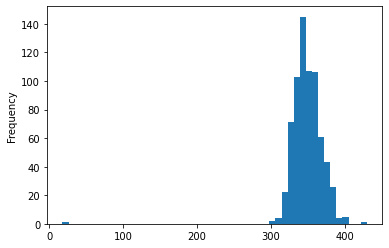

In [617]:
normalised_all_data_final.gcse_2013.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

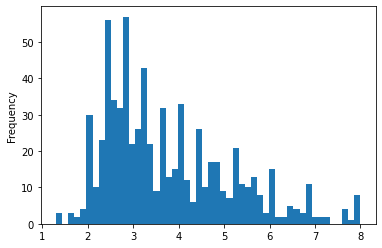

In [618]:
normalised_all_data_final.ptal_2013.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

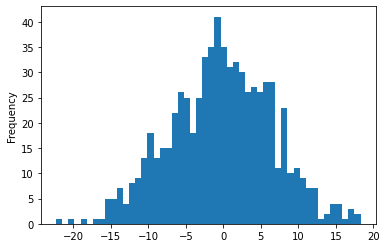

In [619]:
normalised_all_data_final.nature_access_2013.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

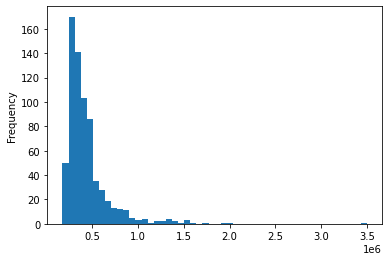

In [620]:
normalised_all_data_final.median_house_2014.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

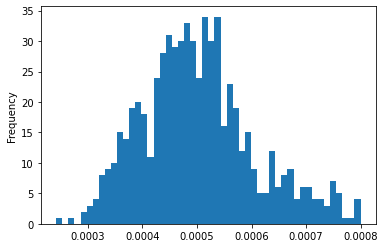

In [621]:
normalised_all_data_final.normalised_deaths_at_6_pc.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

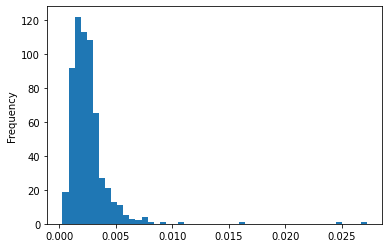

In [622]:
normalised_all_data_final.normalised_2013_collision_total.plot.hist(bins=50)

| Variable | Units | Mean | Skew | Sdv. |
| :- | :- | :-: | :-: | :-: |
| GCSE Scores | - | # | # | # |
| PTAL | Density score 0-9| # | # | # |
| Nature Access Scores | Homes with access to open space, <br> and proportion of area that is greenspace| # | # | # |
| Median House Price | £ | # | # | # |
| Air Pollution Mortality | Count | # | # | # |
| Total traffic accidents | Count | # | # | # |


### 4. Normalising Data (Richy)

| Variable | Noralised | Reasoning/Method |
| :- | :- | :-: |
| GCSE Scores | No | the average of each students top 8 grades |
| PTAL | No | Effectively a density. File meta data says ‘The method is essentially a way of measuring the density of the public transport network at any location within Greater London.’
 |
| Nature Access Scores | No| its a score determined by an equal weighting of ‘Homes with access to open space, and proportion of ward that is greenspace’. I would assume they have taken homes with access to open space to be a %, and proportion to be a % too, so already normalised. | # | # |
| Median House Price | No | £ same value in each ward |
| Air Pollution Mortality | Yes | Divide by ward population  |
| Total traffic accidents | Yes | Divide by ward population |



In [624]:
# delete colulmns that arent floats so we can rescale float columns
# note .drop doesnt seem to work and im not sure why so using del, even though its a bit less elegant!

del normalised_all_data_final["ward_code_x"]
del normalised_all_data_final["ward_name_x"]
del normalised_all_data_final["ward_name_y"]
del normalised_all_data_final["Population"]
del normalised_all_data_final["ward_code_y"]
del normalised_all_data_final["ward_name"]
del normalised_all_data_final["ward_code"]
del normalised_all_data_final["2013_collision_total"]
del normalised_all_data_final["deaths_at_6_pc"]



In [625]:
normalised_all_data_final

,gcse_2013,ptal_2013,nature_access_2013,median_house_2014,normalised_deaths_at_6_pc,normalised_2013_collision_total
0,360.0,7.9,-6.5,765000.0,0.000494,NaN
1,360.0,7.9,-6.5,765000.0,0.000494,NaN
2,334.0,6.0,-0.9,173000.0,0.000542,0.003051
3,334.0,6.0,-0.9,173000.0,0.000407,0.003051
4,358.0,5.1,-0.8,482500.0,0.000755,0.004528
...,...,...,...,...,...,...
852,NaN,NaN,NaN,NaN,NaN,NaN
853,NaN,NaN,NaN,NaN,NaN,NaN
854,NaN,NaN,NaN,NaN,NaN,NaN
855,NaN,NaN,NaN,NaN,NaN,NaN


In [626]:
normalised_all_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857 entries, 0 to 856
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   gcse_2013                        701 non-null    float64
 1   ptal_2013                        700 non-null    float64
 2   nature_access_2013               700 non-null    float64
 3   median_house_2014                700 non-null    float64
 4   normalised_deaths_at_6_pc        646 non-null    float64
 5   normalised_2013_collision_total  611 non-null    float64
dtypes: float64(6)
memory usage: 46.9 KB


### 5. Rescaling the data ready for clustering (Nene)

In [627]:
# change index to int so rescaling works
normalised_all_data_final.index = normalised_all_data_final.index.map(int) 

In [628]:
# second method for chagining index to int
normalised_all_data_final.index.astype(int, copy = False)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            847, 848, 849, 850, 851, 852, 853, 854, 855, 856],
           dtype='int64', length=857)

In [629]:
# Initialise the robus recaler
rbs = RobustScaler(quantile_range=[0.05,0.95])

In [630]:
# Rescale
standardised_all_data = []

for c in normalised_all_data_final:
    standardised_all_data[c] = rbs.fit_transform(normalised_all_data_final[c].values.reshape(-1,1))
    
# Check
standardised_all_data(3)

TypeError: list indices must be integers or slices, not str

### 6. Summarise statistical summary of the rescaled data (Richy)